In [26]:
import os
import json
import ast
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.patches as patches

In [27]:
model_name = "GeneMamba_24l_512d"

current_path = os.getcwd()


SAVE_PATH = os.path.join(current_path, 'results', model_name)

In [28]:
metrics_dir = os.path.join(SAVE_PATH, "metrics")

In [29]:
def summarize_metrics(metrics_dir='metrics', include_macro_f1=True):
    """
    Summarize metrics across files and plot them as a grouped bar chart.
    
    Parameters:
    - metrics_dir (str): Directory containing the metric files.
    - include_macro_f1 (bool): Whether to include "Macro-F1 score" in the summary.
    """
    # Dictionary to store metrics by dataset
    datasets = {}

    # Loop through each file in the directory
    for filename in os.listdir(metrics_dir):
        if filename.endswith('.txt'):
            # Extract dataset name by splitting the filename
            dataset_name = filename.split('_')[1]

            # Read the file and evaluate the dictionary string to a Python dictionary
            with open(os.path.join(metrics_dir, filename), 'r') as f:
                metrics = ast.literal_eval(f.read())
            
            # Append metrics to the corresponding dataset list
            if dataset_name not in datasets:
                datasets[dataset_name] = []
            datasets[dataset_name].append(metrics)

    # Compute the average metrics for each dataset
    summary_metrics = {}
    for dataset, metrics_list in datasets.items():
        # Convert the list of metrics to a DataFrame for easier aggregation
        df = pd.DataFrame(metrics_list)
        
        # Drop "Macro-F1 score" column if not included
        if not include_macro_f1 and 'Macro-F1 score' in df.columns:
            df = df.drop(columns=['Macro-F1 score'])
        
        summary_metrics[dataset] = df.max().to_dict()

    # Convert summary_metrics to a DataFrame for plotting
    summary_df = pd.DataFrame(summary_metrics)

    # Plot all metrics in a single grouped bar chart
    summary_df.T.plot(kind='bar', figsize=(12, 8), width=0.8)
    plt.title('Comparison of Metrics Across Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Metric Value')

    # hide top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('comparison_of_metrics.png', dpi=300)
    plt.show()

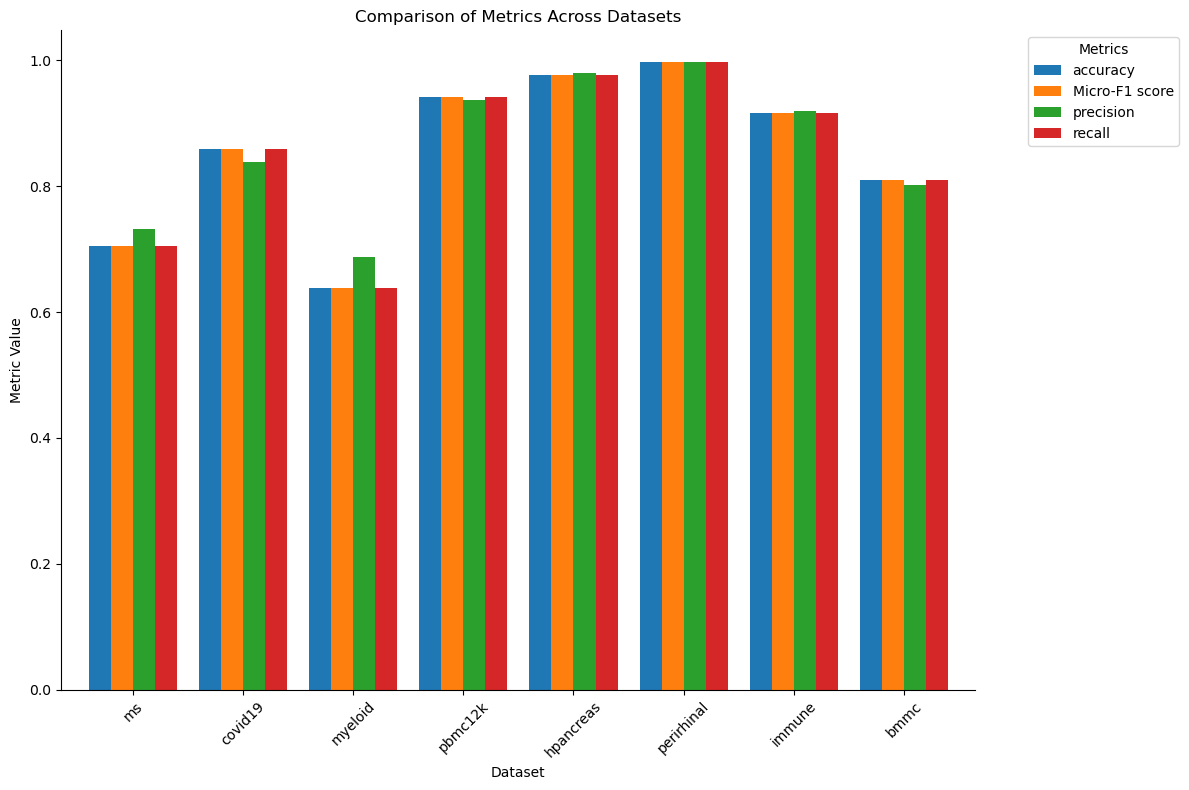

In [30]:
summarize_metrics(metrics_dir=metrics_dir, include_macro_f1=False)

In [31]:
def draw_confusion_matrix(y_true, y_pred, num_classes, dataset_name):

    # compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(12, 10), dpi = 300)

    def get_text_color(value, threshold=0.5):
        return "white" if value > threshold else "black"

    # plot the heatmap
    ax = sns.heatmap(cm, annot=True, cmap="Purples", fmt=".2f", cbar=False, square=True,
                    annot_kws={"size": 8},
                    xticklabels=False, yticklabels=False)

    for text in ax.texts:
        value = float(text.get_text())
        text.set_color(get_text_color(value))

    for i in range(num_classes):
        color = plt.cm.tab20(i / num_classes)
        ax.add_patch(patches.Rectangle((i, -1), 1, 1, color=color, transform=ax.transData, clip_on=False))
        ax.add_patch(patches.Rectangle((-1, i), 1, 1, color=color, transform=ax.transData, clip_on=False))

    # plt.title(f"Confusion matrix for MS\nAccuracy: {accuracy:.2f}, Micro-F1: {micro_f1:.2f}")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    # plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()


In [32]:
def visualization(dataset_name, epoch):
        
    predictions_dir = os.path.join(SAVE_PATH, "predictions")

    # load the predictions
    pred_prob = np.load(os.path.join(predictions_dir, f"pred_prob_{dataset_name}_{epoch}.npy"))
    pred_labels = np.load(os.path.join(predictions_dir, f"pred_label_{dataset_name}_{epoch}.npy"))
    true_labels = np.load(os.path.join(predictions_dir, f"targets_{dataset_name}_{epoch}.npy"))

    cell_repr = np.load(os.path.join(SAVE_PATH, f"repr/{dataset_name}_test_cell_repr.npy"))

    num_classes = max(len(np.unique(true_labels)), len(np.unique(pred_labels)))

    # num_classes = len(np.unique(pred_labels))
    draw_confusion_matrix(true_labels, pred_labels, num_classes, dataset_name)


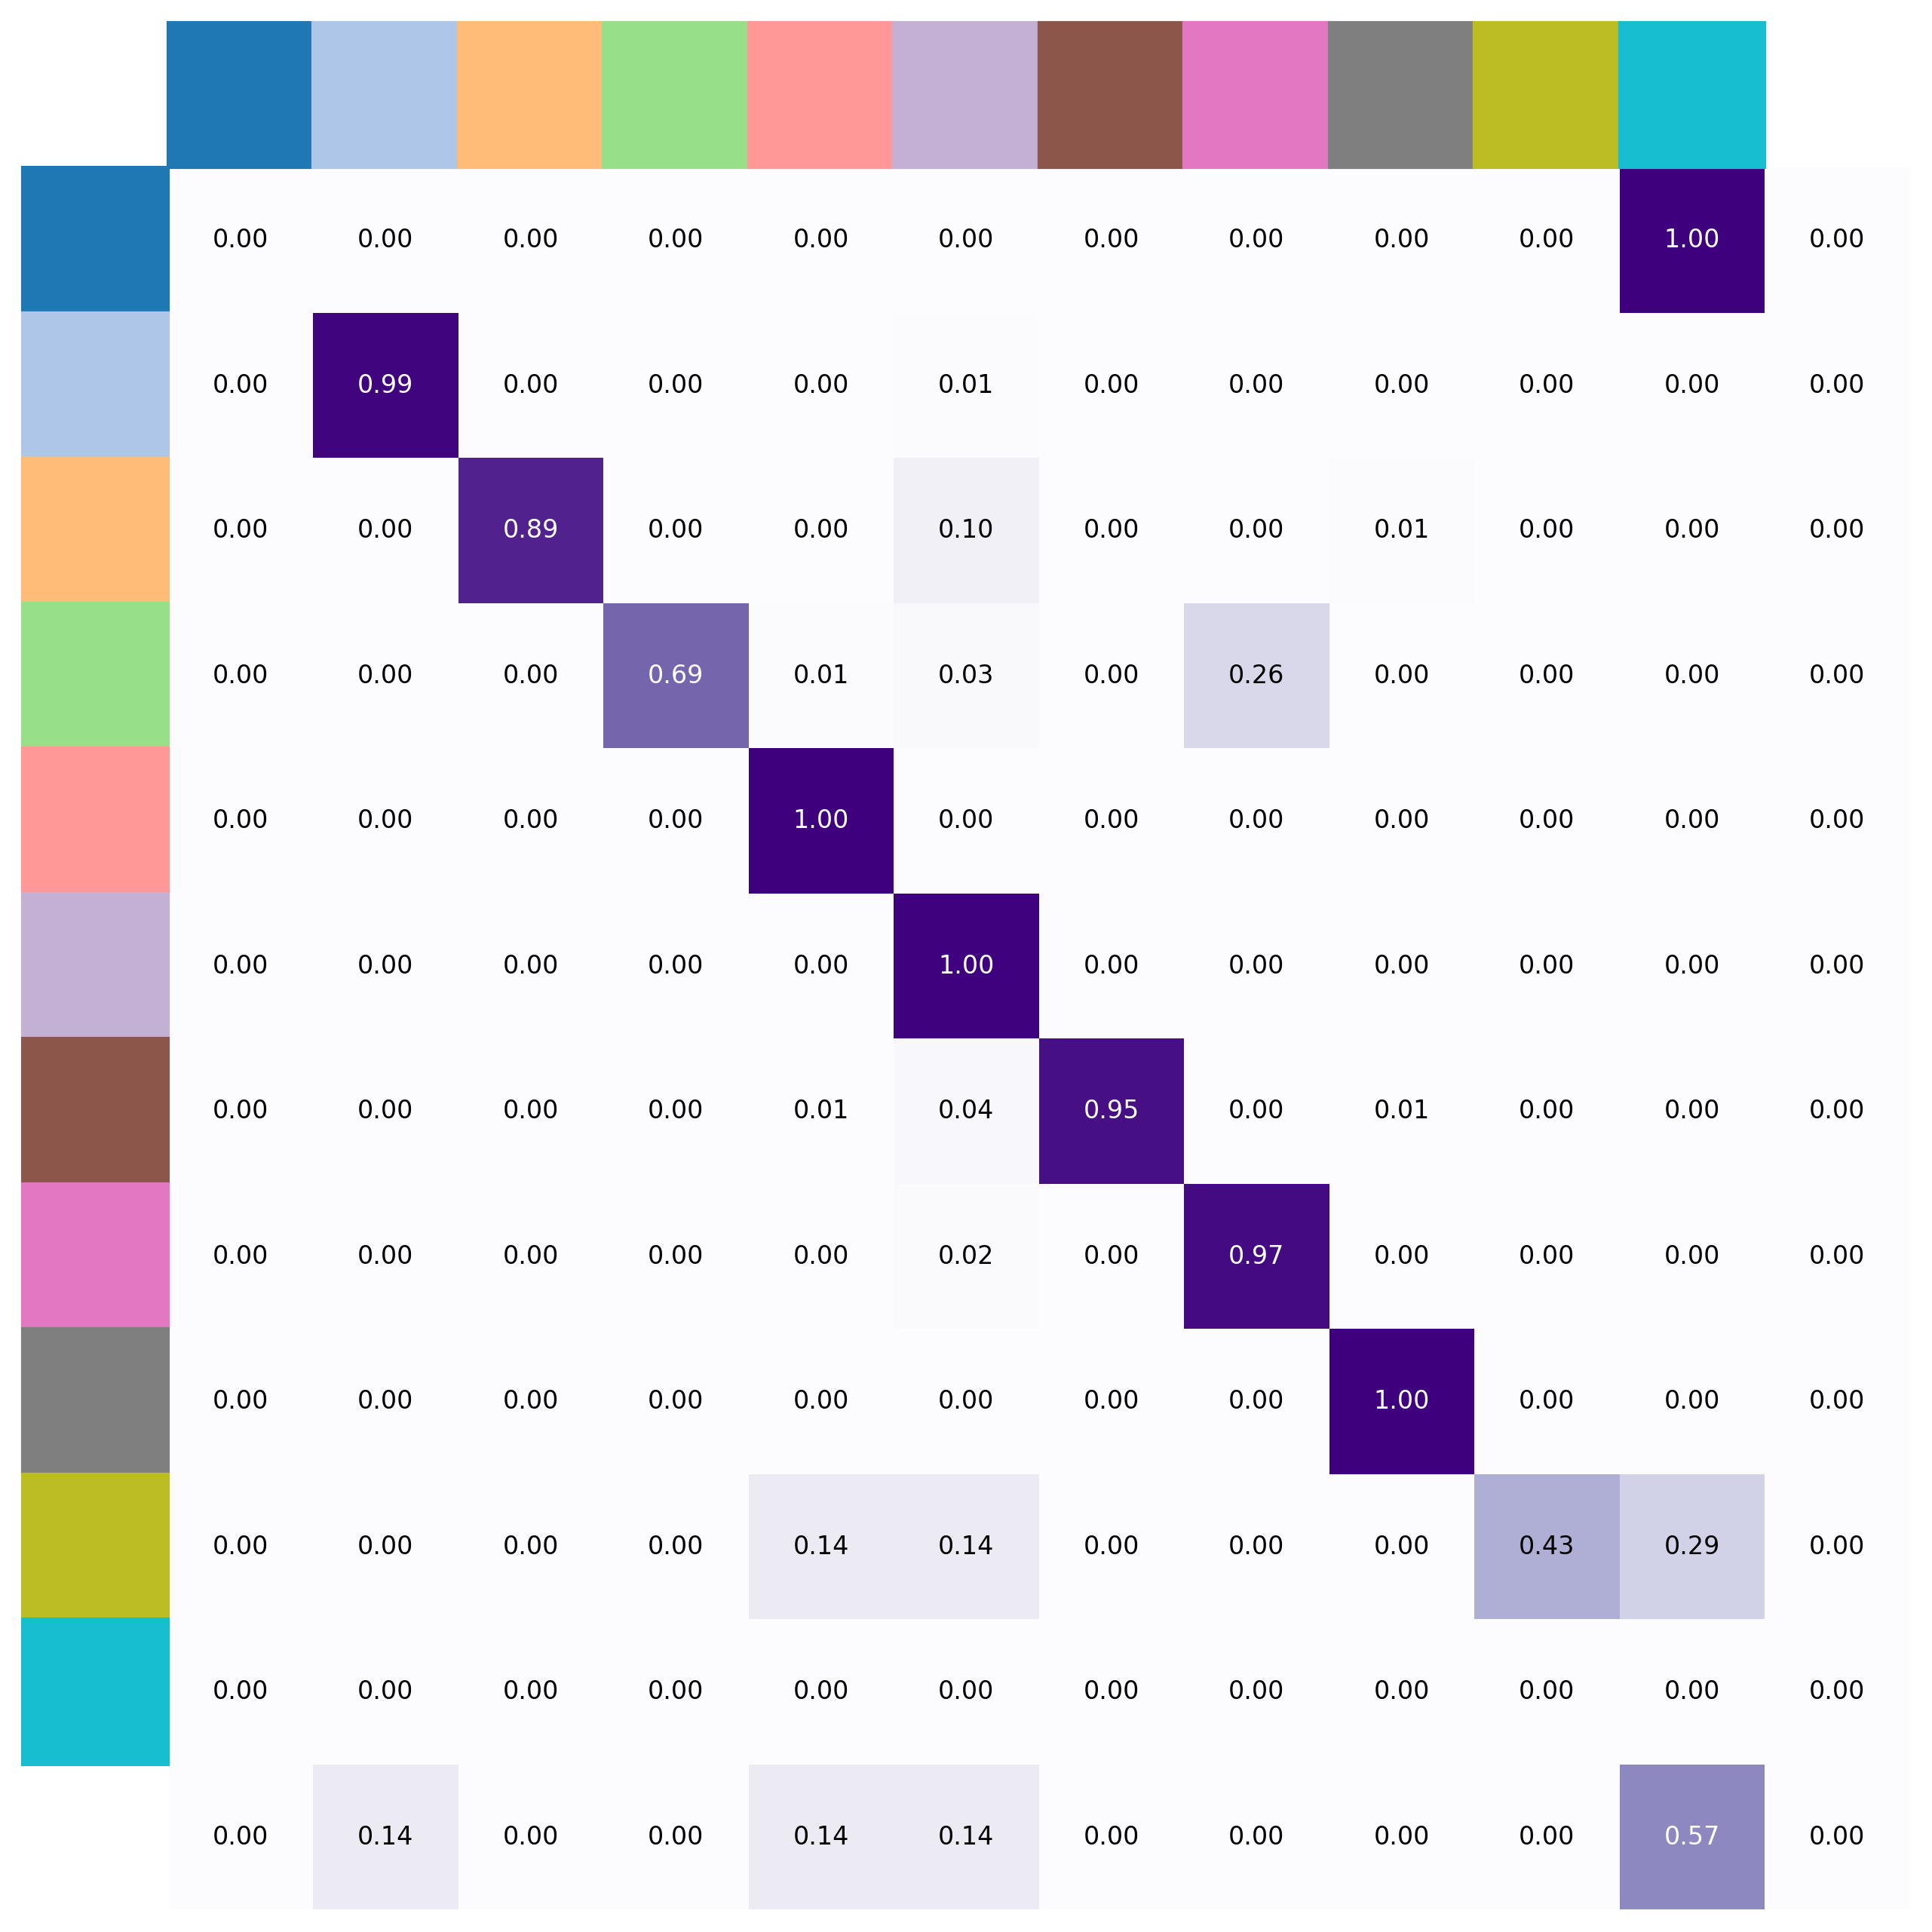

In [33]:
# replcace the dataset name and epoch number to visualize the confusion matrix
visualization(dataset_name = "hpancreas", epoch = 5)